## Importing Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Loading the data

In [ ]:
columns = ['id','country','Label','Text']
data = pd.read_csv('twitter_training.csv', names=columns)

### Data Preview

In [4]:
data.head()

,id,country,Label,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [6]:
data.shape

(74682, 4)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       74682 non-null  int64 
 1   country  74682 non-null  object
 2   Label    74682 non-null  object
 3   Text     73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [8]:
data['Label'].value_counts()

,count
Label,
Negative,22542
Positive,20832
Neutral,18318
Irrelevant,12990


## Data Preprocessing

In [9]:
data.dropna(inplace=True)

### Tokenization, StopWord Removal, Lemmatization

In [10]:
def preprocess(text):
    tokenized = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    stopwords_removed = [token for token in tokenized if token not in stop_words and token not in punctuation]

    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in stopwords_removed]

    return " ".join(lemmatized)

In [11]:
data['Preprocessed Text'] = data['Text'].apply(preprocess)

### Label Columns in Numbers
#### (Irrelevant = 0, Negative = 1,  Nuetral = 2,  Positive = 3)

In [12]:
le_model = LabelEncoder()
data['Label'] = le_model.fit_transform(data['Label'])

In [13]:
data.head()

,id,country,Label,Text,Preprocessed Text
0,2401,Borderlands,3,im getting on borderlands and i will murder yo...,im getting borderland murder
1,2401,Borderlands,3,I am coming to the borders and I will kill you...,I coming border I kill
2,2401,Borderlands,3,im getting on borderlands and i will kill you ...,im getting borderland kill
3,2401,Borderlands,3,im coming on borderlands and i will murder you...,im coming borderland murder
4,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...,im getting borderland 2 murder


### 'id' and 'country' columns are not required for analysis, So drop these Columns.

In [14]:
data = data.drop(['id', 'country'], axis = 1)

### Checking Null values

In [15]:
data.isnull().sum()

,0
Label,0
Text,0
Preprocessed Text,0


## Visualizing Data

### Distibution of Labels
#### (Irrelevant = 0, Negative = 1,  Nuetral = 2,  Positive = 3)

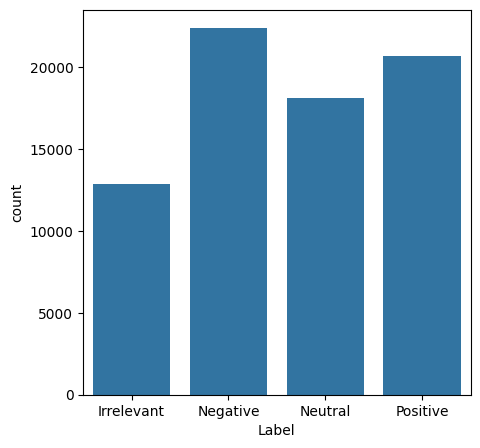

In [17]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='Label', data = data)
plt.xticks([0, 1, 2, 3], ['Irrelevant', 'Negative', 'Neutral', 'Positive'])
plt.show()

## Training the model

### Defining dependent and independent variable as x and y.

In [18]:
x = data['Preprocessed Text'].values
y = data['Label'].values

### Splitting the dataset into training set and testing set.

In [19]:
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42, stratify=data['Label'])

### Naive Bayes(Random Forest Classifier)

In [20]:
clf = Pipeline([
    ('vectorizer_tri_grams', TfidfVectorizer()),
    ('naive_bayes', (RandomForestClassifier()))
])

### Training

In [21]:
clf.fit(x_train, y_train)

Pipeline(steps=[('vectorizer_tri_grams', TfidfVectorizer()),
                ('naive_bayes', RandomForestClassifier())])

In [22]:
y_pred = clf.predict(x_test)

### Accuracy Report

In [23]:
print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.9214189189189189


In [24]:
print("Classifiation Report: \n\n", classification_report(y_test, y_pred))

Classifiation Report: 

               precision    recall  f1-score   support

           0       0.97      0.87      0.92      2575
           1       0.93      0.94      0.93      4472
           2       0.94      0.91      0.92      3622
           3       0.87      0.95      0.91      4131

    accuracy                           0.92     14800
   macro avg       0.93      0.92      0.92     14800
weighted avg       0.92      0.92      0.92     14800



## User Prediction

In [25]:
def predict_tweet_sentiment(tweet_text):
    cleaned_text = preprocess(tweet_text)

    prediction_idx = clf.predict([cleaned_text])

    prediction_label = le_model.inverse_transform(prediction_idx)

    return prediction_label[0]

while True:
    user_input = input("\nEnter a tweet to analyze (or type 'exit' to quit): ")

    if user_input.lower() in ['exit', 'quit']:
        print("Exiting...")
        break

    if user_input.strip() == "":
        continue

    sentiment = predict_tweet_sentiment(user_input)
    print(f"Predicted Sentiment: {sentiment}")


Enter a tweet to analyze (or type 'exit' to quit): I am Very Hungry
Predicted Sentiment: Irrelevant

Enter a tweet to analyze (or type 'exit' to quit): I don't feel like Happy
Predicted Sentiment: Positive

Enter a tweet to analyze (or type 'exit' to quit): I am very Sad
Predicted Sentiment: Negative

Enter a tweet to analyze (or type 'exit' to quit): I dont give a Fuck about anything
Predicted Sentiment: Negative

Enter a tweet to analyze (or type 'exit' to quit): exit
Exiting...


## Saving the Trained Model

In [27]:
import joblib

# Save the pipeline (includes vectorizer and Random Forest)
joblib.dump(clf, '/content/drive/MyDrive/Semester 5/Twitter Sentiment Analysis/sentiment_model.pkl')

# Save the Label Encoder (to convert numbers back to text labels)
joblib.dump(le_model, '/content/drive/MyDrive/Semester 5/Twitter Sentiment Analysis/label_encoder.pkl')

print("Model and Label Encoder saved successfully!")

Model and Label Encoder saved successfully!
